Añado aquí lo del los errores x, y, z separados 

# 3-PINN pero añado la identificacion de los parámetros  

In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import plotly.express as px



In [84]:
#definicion de parámetros etc  

#parámetros del material
#E = 0.032
#nu = 0.4

#relacion lineal entre tension y deformación
# C=(E/((1+nu)*(1-2*nu)))*torch.tensor(
#     [[1-nu,nu,nu,0,0,0],
#      [nu,1-nu,nu,0,0,0],
#      [nu,nu,1-nu,0,0,0],
#      [0,0,0,(1-2*nu)/2,0,0],
#      [0,0,0,0,(1-2*nu)/2,0],
#      [0,0,0,0,0,(1-2*nu)/2]]).cuda()

#G = E/(2*(1+nu))


seed_id = 1234

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(device))

# Set default dtype to float32
torch.set_default_dtype(torch.float32)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

Using device: cuda
NVIDIA A2


# Funciones para la carga y le tratado de los datos


In [85]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

In [86]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [87]:
#vamos a hacer una función para cargar todos los datos de una   
def load_data(load_stage=1):
    # carga las posiciones de los nodos    
    ititialPosition_data_path = "./data/ARTURO_TEST_1/NODES.txt"

    with open(ititialPosition_data_path,"r") as f:
        aux_list=f.readlines()

    ititialPosition_data=[i for i in aux_list if keep_line(i)]
    ititialPosition_data=[i.strip("\n") for i in ititialPosition_data]
    ititialPosition_data=[i.split() for i in ititialPosition_data]
    ititialPosition_data_np=np.array(ititialPosition_data).astype(float)[:,[0,1,2,3]]
    ititialPosition_data_pd=pd.DataFrame(ititialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")

    #carga el streess
    stress_data_path = f"./data/LINEAR_SMALL_DISP/PSOL_{load_stage}_NODAL_STRESSES.txt"

    with open(stress_data_path,"r") as f:
        aux_list=f.readlines()


    stress_data=[i for i in aux_list if keep_line(i)]
    stress_data=[i.strip("\n").strip() for i in stress_data]
    patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

    stress_data=[re.findall(patron,i) for i in stress_data]
    stress_data=np.array(stress_data,dtype=float)
    stress_data=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")

    # cargar datos de desplazamiento  
    displacement_data_path = f"./data/LINEAR_SMALL_DISP/PSOL_{load_stage}_NODAL_DISP.txt"

    with open(displacement_data_path,"r") as f:
        aux_list=f.readlines()


    displacement_data=[i for i in aux_list if keep_line(i)]
    displacement_data=[i.strip("\n").strip() for i in displacement_data]
    patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

    displacement_data=[re.findall(patron,i) for i in displacement_data]
    displacement_data=np.array(displacement_data,dtype=float)
    displacement_data=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

    # cargar datos de boundaries en el movimiento
    #cargar los nodos fijos
    with open("./data/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
        restricted_data=f.readlines()

    restricted_data=[i for i in restricted_data if keep_line(i)]
    restricted_data=[i.strip("\n") for i in restricted_data]
    restricted_data=[i.split() for i in restricted_data]
    restricted_data_np=np.array(restricted_data)[:,[0,1]]
    restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
    restricted_data_pd=restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
    restricted_data_pd.index=restricted_data_pd.index.astype(int)
    restricted_data_pd=restricted_data_pd.sort_index()
    restricted_data_pd=restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

    with open("./data/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
        force_data=f.readlines()


    force_data=[i for i in force_data if keep_line(i)]
    force_data=[i.strip("\n") for i in force_data]
    force_data=[i.split() for i in force_data]
    force_data_np=np.array(force_data)[:,[0,1,2]]
    force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
    force_data_pd["Fuerza"]=force_data_pd["Fuerza"].astype(float)
    force_data_pd=force_data_pd.set_index("Node")
    force_data_pd.index=force_data_pd.index.astype(int)


    #ponemos todos los datos en común usando los nodos como clave   
    final_data=ititialPosition_data_pd.merge(stress_data,left_index=True,right_index=True,how="left").merge(force_data_pd,left_index=True,right_index=True,how="left").merge(displacement_data,left_index=True,right_index=True,how="left").merge(restricted_data_pd,left_index=True,right_index=True,how="left")

    final_data["Final_X"]=final_data["X"]-final_data["UX"]
    final_data["Final_Y"]=final_data["Y"]-final_data["UY"]
    final_data["Final_Z"]=final_data["Z"]-final_data["UZ"]


    return final_data

In [88]:
final_df=load_data(10)
final_df

X       Y       Z        SX        SY        SZ       SXY  \
Node                                                                     
1.0     46.726  41.840  17.459  0.000636 -0.000977  0.000060  0.000581   
2.0     31.149  44.342  17.410  0.000533 -0.001960  0.000172 -0.000703   
3.0     54.619  26.576  39.528 -0.000683 -0.001899 -0.000488  0.000108   
4.0     63.720  39.982  42.026  0.000155  0.000046  0.000146 -0.000109   
5.0     19.543  50.820  41.746 -0.000326 -0.000673  0.003965 -0.001020   
...        ...     ...     ...       ...       ...       ...       ...   
4147.0  47.957  36.969  40.653       NaN       NaN       NaN       NaN   
4148.0  43.244  36.666  35.819       NaN       NaN       NaN       NaN   
4149.0  46.140  37.853  37.430       NaN       NaN       NaN       NaN   
4150.0  45.523  41.517  35.879       NaN       NaN       NaN       NaN   
4151.0  37.146  41.910  32.202       NaN       NaN       NaN       NaN   

             SYZ       SXZ Direccion_Fuerza  Fuerza        UX       UY  \
Node                                                                     
1.0     0.000165  0.000284              NaN     NaN  0.383590 -1.64530   
2.0     0.000093 -0.000284              NaN     NaN -0.317510 -1.94210   
3.0    -0.000060 -0.000340              NaN     NaN  0.197710  0.00000   
4.0    -0.000693  0.000093              NaN     NaN  0.212900 -0.21741   
5.0    -0.001728 -0.000881              NaN     NaN -0.142780 -0.44734   
...          ...       ...              ...     ...       ...      ...   
4147.0       NaN       NaN              NaN     NaN  0.227120 -0.64232   
4148.0       NaN       NaN              NaN     NaN  0.096754 -0.75938   
4149.0       NaN       NaN              NaN     NaN  0.156120 -0.75100   
4150.0       NaN       NaN              NaN     NaN  0.141090 -1.08910   
4151.0       NaN       NaN              NaN     NaN -0.020524 -1.33940   

              UZ     USUM Restricciones    Final_X   Final_Y    Final_Z  
Node                                                                     
1.0    -0.519970  1.76760           NaN  46.342410  43.48530  17.978970  
2.0    -0.684740  2.08360           NaN  31.466510  46.28410  18.094740  
3.0     0.085179  0.21528          [UY]  54.421290  26.57600  39.442821  
4.0    -0.096805  0.31932           NaN  63.507100  40.19941  42.122805  
5.0     0.251500  0.53268           NaN  19.685780  51.26734  41.494500  
...          ...      ...           ...        ...       ...        ...  
4147.0  0.380410  0.78030           NaN  47.729880  37.61132  40.272590  
4148.0  0.206120  0.79278           NaN  43.147246  37.42538  35.612880  
4149.0  0.271850  0.81380           NaN  45.983880  38.60400  37.158150  
4150.0  0.166770  1.11080           NaN  45.381910  42.60610  35.712230  
4151.0 -0.068341  1.34130           NaN  37.166524  43.24940  32.270341  

[4151 rows x 19 columns]

In [89]:
def get_colloc_points(final_df,n_points=None,type="random_1"):
    min_X=final_df["X"].min()
    max_X=final_df["X"].max()

    min_Y=final_df["Y"].min()
    max_Y=final_df["Y"].max()

    min_Z=final_df["Z"].min()
    max_Z=final_df["Z"].max()

    global Pos_min
    global Pos_max

    Pos_min = torch.tensor([min_X, min_Y, min_Z])
    Pos_max = torch.tensor([max_X, max_Y, max_Z])

    if type=="random_1":

        X_coloc = np.random.uniform(min_X, max_X, (n_points, 1))
        Y_coloc = np.random.uniform(min_Y, max_Y, (n_points, 1))
        Z_coloc = np.random.uniform(min_Z, max_Z, (n_points, 1))
        col_points = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
        
        #train_coloc = torch.tensor(comb_array,requires_grad=True).to(device)   
        return col_points
    
    elif type=="random_2":
        #este tipo de random es una distribucion por todo el espacio para cada punto
        points=[]
        for _ in range(n_points):
            X_coloc_aux = np.random.uniform(min_X, max_X, 1)
            Y_coloc_aux = np.random.uniform(min_Y, max_Y, 1)
            Z_coloc_aux = np.random.uniform(min_Z, max_Z, 1)
            points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

        return np.array(points).reshape(-1, 3)

In [90]:
coloc_points=get_colloc_points(final_df,40000,"random_2")

#extraemos del final_df los datos necesarios   
nodos_with_force_data=final_df.loc[final_df.apply(lambda x : (not np.isnan(x.Fuerza)) & (not np.isnan(x.SY)),axis=1),["X","Y","Z","SX","SY","SZ","SXY","SYZ","SXZ","Restricciones"]]
nodos_with_force_data=nodos_with_force_data.loc[nodos_with_force_data["Restricciones"].isna()].drop(columns=["Restricciones"])

not_limited_nodes_data=final_df.loc[final_df.apply(lambda x : np.isnan(x["Restricciones"]) if not isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

notlimited_traindata=not_limited_nodes_data.sample(frac=0.8,axis=0)
notlimited_testdata=not_limited_nodes_data.loc[[i not in notlimited_traindata.index for i in not_limited_nodes_data.index]]

data_BC_fix3=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==3 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix1_Y=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==1 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

train_data=pd.concat([notlimited_traindata,data_BC_fix3,data_BC_fix1_Y])
train_data=train_data.sample(frac=1) #esto está para shuflear




train_coloc = torch.tensor(coloc_points,requires_grad=True).to(device)

xyz_train=torch.tensor(train_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_train=torch.tensor(train_data[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

xyz_bc_train=torch.tensor(nodos_with_force_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)

sigma_bc_train=torch.tensor(nodos_with_force_data[["SX","SY","SZ","SXY","SXZ","SYZ"]].to_numpy(),requires_grad=True).to(torch.float32).to(device)


xyz_test=torch.tensor(notlimited_testdata[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_test=torch.tensor(notlimited_testdata[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)


In [146]:
nodos_with_force_data

X       Y       Z        SX        SY        SZ       SXY  \
Node                                                                     
6.0     27.108  57.070  47.311 -0.003914 -0.007067 -0.003272 -0.000960   
183.0   27.980  49.724  25.295 -0.000572 -0.007253  0.001545 -0.002296   
184.0   27.784  49.479  25.129 -0.003629 -0.013755 -0.001093 -0.004871   
225.0   23.861  54.943  41.561 -0.008194 -0.024178 -0.011301 -0.004212   
226.0   24.057  55.159  42.108 -0.007767 -0.018605 -0.009045 -0.001680   
...        ...     ...     ...       ...       ...       ...       ...   
1213.0  39.288  58.288  45.709 -0.002452 -0.003740 -0.000962  0.000103   
1214.0  42.720  58.336  45.498 -0.002060 -0.003153 -0.000480  0.000054   
1215.0  46.066  58.293  46.134 -0.002017 -0.003554 -0.000690  0.000037   
1250.0  36.703  58.297  45.737 -0.002203 -0.003947 -0.001120 -0.000254   
1252.0  48.852  58.303  46.760 -0.002151 -0.004147 -0.001272  0.000145   

             SYZ       SXZ  
Node                        
6.0     0.002325 -0.000228  
183.0   0.002502 -0.001081  
184.0   0.001492 -0.001278  
225.0  -0.001918 -0.000715  
226.0   0.002083 -0.000305  
...          ...       ...  
1213.0 -0.000078 -0.000213  
1214.0  0.000093  0.000120  
1215.0 -0.000205  0.000311  
1250.0 -0.000149 -0.000367  
1252.0 -0.000372  0.000330  

[184 rows x 9 columns]

In [91]:
notlimited_testdata

X       Y       Z        UX       UY       UZ
Node                                                      
9.0     17.625  46.447  49.485 -0.526300 -0.94259  0.33312
10.0    46.169  56.619  52.452  0.037204 -1.78310  0.83357
11.0    20.637  48.231  53.115 -0.589680 -1.19690  0.61135
14.0    27.510  43.059  55.819 -0.513120 -1.19890  0.82102
17.0    27.984  43.548  55.859 -0.497190 -1.22220  0.85140
...        ...     ...     ...       ...      ...      ...
4125.0  36.800  46.684  44.795 -0.056257 -1.87070  0.84771
4130.0  32.057  39.183  46.182 -0.241410 -0.95110  0.65925
4136.0  39.177  40.628  34.756  0.017274 -1.23460  0.10829
4141.0  32.950  41.300  41.128 -0.166090 -1.14450  0.47262
4148.0  43.244  36.666  35.819  0.096754 -0.75938  0.20612

[699 rows x 6 columns]

In [92]:
notlimited_testdata["desp"]=np.sqrt(notlimited_testdata["UX"]**2+notlimited_testdata["UY"]**2+notlimited_testdata["UZ"]**2)
notlimited_testdata

/tmp/ipykernel_72212/439226803.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



X       Y       Z        UX       UY       UZ      desp
Node                                                                
9.0     17.625  46.447  49.485 -0.526300 -0.94259  0.33312  1.129795
10.0    46.169  56.619  52.452  0.037204 -1.78310  0.83357  1.968672
11.0    20.637  48.231  53.115 -0.589680 -1.19690  0.61135  1.467665
14.0    27.510  43.059  55.819 -0.513120 -1.19890  0.82102  1.541015
17.0    27.984  43.548  55.859 -0.497190 -1.22220  0.85140  1.570303
...        ...     ...     ...       ...      ...      ...       ...
4125.0  36.800  46.684  44.795 -0.056257 -1.87070  0.84771  2.054579
4130.0  32.057  39.183  46.182 -0.241410 -0.95110  0.65925  1.182151
4136.0  39.177  40.628  34.756  0.017274 -1.23460  0.10829  1.239460
4141.0  32.950  41.300  41.128 -0.166090 -1.14450  0.47262  1.249334
4148.0  43.244  36.666  35.819  0.096754 -0.75938  0.20612  0.792783

[699 rows x 7 columns]

In [93]:
px.scatter_3d(pd.DataFrame.from_records(coloc_points,columns=["X","Y","Z"]),"X","Y","Z")

In [94]:
px.scatter_3d(notlimited_testdata,"X","Y","Z",color="desp")

## Modelo   


In [95]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.layers=layers
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        xn = normalize(x, Pos_min, Pos_max)         # Normalize the input

        # #convert to float
        a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

In [147]:
class PINN(DNN):
    def __init__(self, layers,init_values=None):
        super().__init__(layers)
        
        self.to(device)    
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        'Parameters trials'
        self.params_history = { "nu": [],
                                "E": [] }

        self.nu=init_values[0]#nn.Parameter(torch.tensor(init_values[0],dtype=torch.float32).to(device))#torch.tensor(init_values[0],dtype=torch.float32).to(device)#
        self.E_ref=0.05
        self.alpha=nn.Parameter(torch.tensor(init_values[1],dtype=torch.float32).to(device))
    

        # self.register_parameter('nu', self.nu)  
        # self.register_parameter('E', self.E)
    def loss_data(self, x, u_real, save = False):
        #aqui están las restricciones de movimiento tanto de xyz como las de y solo
        #estamo suponiendo que eso es suficiente para que la red lo aprenda
        #le estamos metiendo todos los nodos que están quietos, y también le vamos a meter
        #todos los que solo se pueden desplazar en dos direcciones, 

        #esta pendiente, en estos con una restriccion en una sola dirección, calcular la loss
        #SOLO en esa direccion 

        
        u_nn = self(x)
     
        #loss_d = self.loss_function(u_nn, u_real)
        loss_d=torch.stack([self.loss_function(u_nn[:,i],u_real[:,i]) for i in range(3) ]).mean()
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):

        nu=self.nu 
                       
        # clone the input data and add AD
       
        pos = pos_f.clone().to(torch.float32)

        # predict u
        U = self(pos)

        #primeras derivadas 

        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        U_shifted1 = torch.roll(U, 1, 1)
        dU_1 = autograd.grad(U_shifted1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]
        U_shifted2 = torch.roll(U, 1, 1)
        dU_2 = autograd.grad(U_shifted2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # second derivatives

        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)
        w_zz = ddU[:,2].reshape(-1,1)

        ddU_1 = autograd.grad(dU_1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xx = ddU_1[:,0].reshape(-1,1)
        u_yy = ddU_1[:,1].reshape(-1,1)
        v_zz = ddU_1[:,2].reshape(-1,1)

        ddU_2 = autograd.grad(dU_2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xx = ddU_2[:,0].reshape(-1,1)
        w_yy = ddU_2[:,1].reshape(-1,1)
        u_zz = ddU_2[:,2].reshape(-1,1)


        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        cross_ddU_1 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xz = cross_ddU_1[:,0].reshape(-1,1)
        u_yx = cross_ddU_1[:,1].reshape(-1,1)
        v_zy = cross_ddU_1[:,2].reshape(-1,1)

        cross_ddU_2 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xy = cross_ddU_2[:,0].reshape(-1,1)
        w_yz = cross_ddU_2[:,1].reshape(-1,1)
        u_zx = cross_ddU_2[:,2].reshape(-1,1)

        f = [(u_xx+u_yy+u_zz) + (1)/(1-2*nu)*(u_xx + v_xy + w_xz),
             (v_xx+v_yy+v_zz) + (1)/(1-2*nu)*(u_yx + v_yy + w_yz),
             (w_xx+w_yy+w_zz) + (1)/(1-2*nu)*(u_zx + v_zy + w_zz) ]

        f_tensor= torch.cat((f[0], f[1], f[2]), dim=1).to(torch.float32).to(device)
        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        f_real=torch.zeros_like(f_tensor).to(torch.float32).to(device)
        #loss_f=torch.stack([self.loss_function(f_tensor[:,i],f_real[:,i]) for i in range(3) ]).mean()
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor).to(torch.float32).to(device) )

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc,sigma_bc, save = False):
        #nuestras condiciones serán hacer que en los nodos donde se aplica la fuerza, las tensiones 
        #sean las registradas para la dirección en la que se aplican, -Y
        
        # clone the input data and add AD
        #pos = pos_bc.clone().to(torch.float32)
        
        # predict U
        X,Y,Z=self.compute_XYZ(pos_bc)
        U,V,W=self.compute_displacements(X,Y,Z)
        
        #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
        nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


        #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
        sigma=self.compute_stress(strain).to(torch.float32)
        sigma_bc=sigma_bc.to(torch.float32)
        #loss_bc = torch.stack([self.loss_function(sigma[:,i],sigma_bc[:,i]) for i in range(3) ]).mean()
        loss_bc = self.loss_function(sigma, sigma_bc) 
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    # Al hacerlo todo desde los desplazamientos, esto no tiene sentido, porque la sigma - *epsilon=0 ya se está cumpliendo por definicion de como calculamos las cosas
    # def loss_constitutive(self,pos_f,save):
    #     #esta los impondra que se cumpla la ecuacion constitutiva de elasticidad lineal  
    #     # predict U
    #     X,Y,Z=self.compute_XYZ(pos_f)
    #     U,V,W=self.compute_displacements(X,Y,Z)
        
    #     #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
    #     nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
    #     strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


    #     #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
    #     sigma=self.compute_stress(strain)
    #     const_res=sigma - 
    #     loss_cons = self.loss_function(const_res, torch.zeros_like(const_res).to(torch.float32).to(device) )



    def loss(self, pos_real, despl_real, pos_f, pos_bc,sigma_bc, save = False):
        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE( pos_f, save) 
        loss_bc = self.loss_BC(pos_bc,sigma_bc, save) 

        loss_val=loss_d+loss_f+loss_bc
        
        #loss_val =loss_d * (1.1-(loss_d/total_aux)) + loss_f * (1.1-(loss_f/total_aux))+ loss_bc * (1.1-(loss_bc/total_aux))
        #loss_val = (1/(epsilon+loss_d))*loss_d  + (1/(epsilon+loss_f))*loss_f + (1/(epsilon+loss_bc))*loss_bc
        if save: 
            E=(1-self.alpha)*self.E_ref
            self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(E.to('cpu').detach().numpy())
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
        return loss_val

    def compute_gradU( self, u, v, w, X, Y, Z, eye=torch.eye(3)):
        # Compute the gradient of U
        Ux = autograd.grad(u, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uy = autograd.grad(u, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uz = autograd.grad(u, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx = autograd.grad(v, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vy = autograd.grad(v, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vz = autograd.grad(v, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of W
        Wx = autograd.grad(w, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wy = autograd.grad(w, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wz = autograd.grad(w, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_stress(self,strain):
        E=(1-self.alpha)*self.E_ref
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(device)

        C=(E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).to(device)
        
        return torch.matmul(C,strain_flat.T.float()).T.squeeze()
    
    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone()
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1)

        # Compute the output of the DNN
        U = self(XYZ)               

        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)

        return u, v, w


In [154]:
'Neural Network Summary'
layers=[3,40,40,20,3]
nu_real = 0.4
nu_init=nu_real#0.1 

E_real = 0.032
E_init=0.6#E_real
pinn = PINN(layers,[nu_init,E_init])

'Neural Network Parameters'
#params = list(pinn.parameters())

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
epochs=3000

start_time = time.time()

for i,epoch in enumerate(range(epochs)):

    print(epoch)

    # Make predictions for this batch
    outputs_xyz = pinn(xyz_train)
    optimizer.zero_grad()
    # Compute the loss and its gradients
    loss = pinn.loss(xyz_train, uvw_train, train_coloc, xyz_bc_train,sigma_bc_train, save = True)
   
    loss.backward()
    #print(pinn.params_history["nu"][-1],pinn.params_history["E"][-1])
    print(
            'Iter: %d, Loss error(Train): %.10f , nu: %.10f , E: %.10f' %
            (   
                i,
                loss.cpu().detach().numpy(),
                pinn.params_history["nu"][-1],
                pinn.params_history["E"][-1]
            )
        )

    # Adjust learning weights
    optimizer.step()

    


elapsed_time = time.time() - start_time
print('Elapsed time: %.10f seconds.' % elapsed_time)

0
Iter: 0, Loss error(Train): 0.4721821249 , nu: 0.4000000000 , E: 0.0199999996
1
Iter: 1, Loss error(Train): 0.4254882634 , nu: 0.4000000000 , E: 0.0199527200
2
Iter: 2, Loss error(Train): 0.3844454885 , nu: 0.4000000000 , E: 0.0199056119
3
Iter: 3, Loss error(Train): 0.3489826918 , nu: 0.4000000000 , E: 0.0198582914
4
Iter: 4, Loss error(Train): 0.3189463615 , nu: 0.4000000000 , E: 0.0198105667
5
Iter: 5, Loss error(Train): 0.2940378785 , nu: 0.4000000000 , E: 0.0197623353
6
Iter: 6, Loss error(Train): 0.2738191485 , nu: 0.4000000000 , E: 0.0197135396
7
Iter: 7, Loss error(Train): 0.2577502728 , nu: 0.4000000000 , E: 0.0196641721
8
Iter: 8, Loss error(Train): 0.2452364415 , nu: 0.4000000000 , E: 0.0196142700
9
Iter: 9, Loss error(Train): 0.2356750816 , nu: 0.4000000000 , E: 0.0195639320
10
Iter: 10, Loss error(Train): 0.2284939289 , nu: 0.4000000000 , E: 0.0195133183
11
Iter: 11, Loss error(Train): 0.2231762856 , nu: 0.4000000000 , E: 0.0194626786
12
Iter: 12, Loss error(Train): 0.21

In [149]:
U = pinn(xyz_train)
pred_u_df=pd.DataFrame(U.cpu().detach().numpy(),columns=["U_pred","V_pred","W_pred"],index=train_data.index)
pred_final=pd.concat([notlimited_traindata,pred_u_df],axis=1)
rel_error_U=((U-uvw_train)/uvw_train).cpu().detach().numpy()
ee_rel_error=rel_error_U[:,0]**2+rel_error_U[:,1]**2+rel_error_U[:,2]**2
pred_final["rel_error"]=ee_rel_error
pred_final[["U_erel","V_erel","W_erel"]]=rel_error_U
pred_final

X       Y       Z        UX        UY        UZ    U_pred  \
Node                                                                     
1142.0  53.522  26.958  36.049  0.108980 -0.039213  0.076179  0.059611   
1912.0  53.020  30.600  34.983  0.057145 -0.048983  0.051537  0.065061   
249.0   50.913  57.039  41.708 -0.342770 -2.788400  0.514390 -0.265944   
2561.0  33.813  40.785  44.221 -0.168960 -1.153600  0.642270 -0.091911   
532.0   43.491  33.094  18.587  0.188230 -1.276400 -0.245330  0.367476   
...        ...     ...     ...       ...       ...       ...       ...   
789.0      NaN     NaN     NaN       NaN       NaN       NaN -0.120472   
1799.0     NaN     NaN     NaN       NaN       NaN       NaN  0.071697   
807.0      NaN     NaN     NaN       NaN       NaN       NaN -0.109152   
7.0        NaN     NaN     NaN       NaN       NaN       NaN -0.211467   
550.0      NaN     NaN     NaN       NaN       NaN       NaN -0.069043   

          V_pred    W_pred  rel_error    U_erel    V_erel    W_erel  
Node                                                                 
1142.0 -0.027495  0.088629   0.751134 -0.812821  0.024922  0.299726  
1912.0 -0.062762  0.073810   0.330801 -0.221972  0.022486 -0.530116  
249.0  -2.485679  0.457702   0.249124  0.210202  0.362155 -0.271630  
2561.0 -1.084620  0.734987   0.016814 -0.125074 -0.001881  0.034155  
532.0  -1.166828 -0.198408        inf  0.227116      -inf -0.023061  
...          ...       ...        ...       ...       ...       ...  
789.0   0.147030 -0.159961        inf  0.295358      -inf -0.028883  
1799.0 -0.013814  0.258330   0.469309 -0.308005  0.459218 -0.404426  
807.0   0.144282 -0.122647   0.004278  0.061736 -0.021485 -0.002155  
7.0    -0.133419  0.350369   0.762179 -0.845493 -0.214520 -0.036070  
550.0   0.050589  0.187573        inf -0.429163       inf  0.193972  

[3452 rows x 13 columns]

In [150]:
df_4_plot=pred_final[["U_erel","V_erel","W_erel"]].stack(level=0).rename("valor").to_frame().reset_index(names=["index","dir"]).replace([np.inf, -np.inf], np.nan)

In [151]:
fig=px.box(df_4_plot,x="dir",y="valor",color="dir")
fig.update_layout(yaxis_range=[-1,1])


/home/arturosf/anaconda3/envs/main_torch/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning:

invalid value encountered in reduce



(-5.0, 5.0)

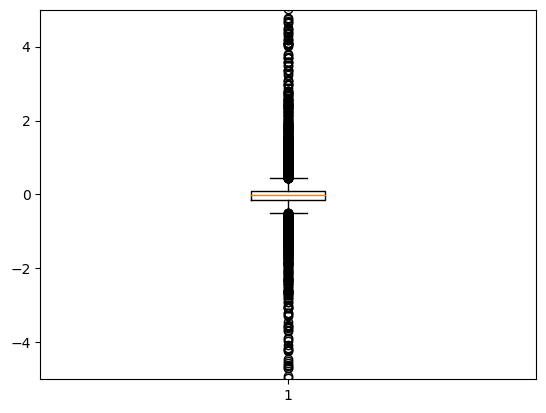

In [111]:
plt.boxplot(rel_error_U.flatten())
plt.ylim(-5,5)

In [135]:
U = pinn(xyz_test)
pred_u_df=pd.DataFrame(U.cpu().detach().numpy(),columns=["U_pred","V_pred","W_pred"],index=notlimited_testdata.index)
pred_final=pd.concat([notlimited_testdata,pred_u_df],axis=1)
rel_error_U=((U-uvw_test)/uvw_test).cpu().detach().numpy()
ee_rel_error=rel_error_U[:,0]**2+rel_error_U[:,1]**2+rel_error_U[:,2]**2
pred_final["rel_error"]=ee_rel_error
pred_final[["U_erel","V_erel","W_erel"]]=rel_error_U
pred_final

X       Y       Z        UX       UY       UZ      desp  \
Node                                                                   
9.0     17.625  46.447  49.485 -0.526300 -0.94259  0.33312  1.129795   
10.0    46.169  56.619  52.452  0.037204 -1.78310  0.83357  1.968672   
11.0    20.637  48.231  53.115 -0.589680 -1.19690  0.61135  1.467665   
14.0    27.510  43.059  55.819 -0.513120 -1.19890  0.82102  1.541015   
17.0    27.984  43.548  55.859 -0.497190 -1.22220  0.85140  1.570303   
...        ...     ...     ...       ...      ...      ...       ...   
4125.0  36.800  46.684  44.795 -0.056257 -1.87070  0.84771  2.054579   
4130.0  32.057  39.183  46.182 -0.241410 -0.95110  0.65925  1.182151   
4136.0  39.177  40.628  34.756  0.017274 -1.23460  0.10829  1.239460   
4141.0  32.950  41.300  41.128 -0.166090 -1.14450  0.47262  1.249334   
4148.0  43.244  36.666  35.819  0.096754 -0.75938  0.20612  0.792783   

          U_pred    V_pred    W_pred  rel_error    U_erel    V_erel    W_erel  
Node                                                                           
9.0    -0.484305 -0.950906  0.393170   0.038940 -0.079792  0.008822  0.180266  
10.0    0.003643 -1.873776  0.775989   0.821114 -0.902085  0.050853 -0.069077  
11.0   -0.654858 -1.186138  0.600824   0.012594  0.110531 -0.008992 -0.017218  
14.0   -0.526142 -1.216582  0.789675   0.002319  0.025378  0.014748 -0.038178  
17.0   -0.511484 -1.244095  0.818238   0.002665  0.028749  0.017915 -0.038950  
...          ...       ...       ...        ...       ...       ...       ...  
4125.0  0.006837 -1.794702  0.945415   1.272761 -1.121529 -0.040625  0.115258  
4130.0 -0.183709 -0.911695  0.707028   0.064097 -0.239015 -0.041431  0.072474  
4136.0  0.057314 -1.181335  0.145190   5.490694  2.317913 -0.043143  0.340749  
4141.0 -0.076644 -1.055157  0.532892   0.312380 -0.538538 -0.078063  0.127528  
4148.0  0.113187 -0.710626  0.259246   0.099399  0.169838 -0.064203  0.257745  

[699 rows x 14 columns]

In [136]:
df_4_plot=pred_final[["U_erel","V_erel","W_erel"]].stack(level=0).rename("valor").to_frame().reset_index(names=["index","dir"]).replace([np.inf, -np.inf], np.nan)

In [139]:
fig=px.box(df_4_plot,x="dir",y="valor",color="dir")

fig.update_layout(yaxis_range=[-1,1])


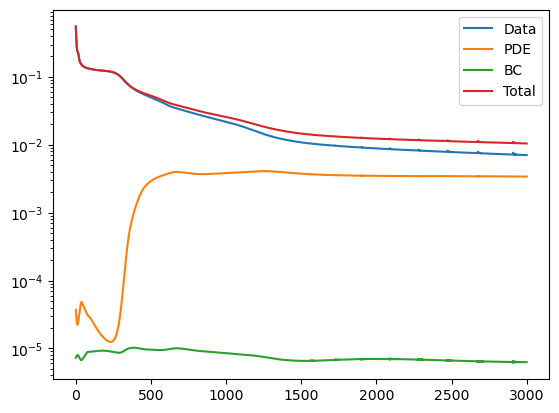

In [152]:
plt.plot(pinn.loss_history["Data"], label='Data')
plt.plot(pinn.loss_history["PDE"], label='PDE')
plt.plot(pinn.loss_history["BC"], label='BC')
plt.plot(pinn.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig('PINN_LEP_Losses.png')

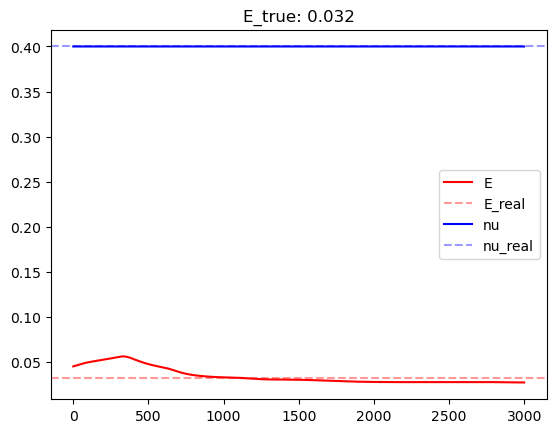

In [153]:
plt.plot(np.arange(epochs),pinn.params_history["E"],color="red",linestyle="-", label='E')
plt.axhline(E_real,color="red",linestyle="--",label='E_real',alpha=0.4)
plt.plot(np.arange(epochs),pinn.params_history["nu"],color="blue",linestyle="-", label='nu')
plt.axhline(nu_real,color="blue",linestyle="--",label='nu_real',alpha=0.4)
plt.title(f"E_true: {E_real:.2g}")

#plt.yscale('log')
plt.legend()
plt.show()


In [123]:
import plotly.graph_objects as go

fig = go.Figure()

# Agregar los puntos con rel_error < 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] < 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] < 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] < 1]["Z"],
    mode='markers',
    marker=dict(
        color=pred_final.loc[pred_final["rel_error"] < 1]["rel_error"],
        colorscale='Viridis',
        size=5,
        colorbar=dict(
            title='Rel_error',
            titleside='right',
            tickmode='auto',
            ticks='outside',
            tickcolor='white',
            ticklen=5,
            showticksuffix='last',
            thickness=20
        )
    ),
    name='Rel_error < 1'
))

# Agregar los puntos con rel_error > 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] > 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] > 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] > 1]["Z"],
    mode='markers',
    marker=dict(
        color='grey',
        opacity=0.5,
        size=5
    ),
    name='Rel_error > 1'
))

# Actualizar el diseño del gráfico
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Mostrar el gráfico
fig.show()


# Pruebas sobre pesos función loss

In [11]:
class PINN2(DNN):
    def __init__(self, layers,init_values=None,weights_losses=None):
        super().__init__(layers)
        self.to(device)    
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        'Parameters trials'
        self.params_history = { "nu": [],
                                "E": [] }
        
        self.wd,self.wpde,self.wbc=weights_losses

        self.nu=init_values[0]#nn.Parameter(torch.tensor(init_values[0],dtype=torch.float32).to(device))#torch.tensor(init_values[0],dtype=torch.float32).to(device)#
        self.E=nn.Parameter(torch.tensor(init_values[1],dtype=torch.float32).to(device))
    

        # self.register_parameter('nu', self.nu)  
        # self.register_parameter('E', self.E)
    def loss_data(self, x, u_real, save = False):
        #aqui están las restricciones de movimiento tanto de xyz como las de y solo
        #estamo suponiendo que eso es suficiente para que la red lo aprenda
        #le estamos metiendo todos los nodos que están quietos, y también le vamos a meter
        #todos los que solo se pueden desplazar en dos direcciones, 

        #esta pendiente, en estos con una restriccion en una sola dirección, calcular la loss
        #SOLO en esa direccion 

        
        u_nn = self(x)
     
        loss_d = self.loss_function(u_nn, u_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):

        nu=self.nu 
                       
        # clone the input data and add AD
       
        pos = pos_f.clone().to(torch.float32)

        # predict u
        U = self(pos)

        #primeras derivadas 

        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        U_shifted1 = torch.roll(U, 1, 1)
        dU_1 = autograd.grad(U_shifted1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]
        U_shifted2 = torch.roll(U, 1, 1)
        dU_2 = autograd.grad(U_shifted2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # second derivatives

        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)
        w_zz = ddU[:,2].reshape(-1,1)

        ddU_1 = autograd.grad(dU_1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xx = ddU_1[:,0].reshape(-1,1)
        u_yy = ddU_1[:,1].reshape(-1,1)
        v_zz = ddU_1[:,2].reshape(-1,1)

        ddU_2 = autograd.grad(dU_2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xx = ddU_2[:,0].reshape(-1,1)
        w_yy = ddU_2[:,1].reshape(-1,1)
        u_zz = ddU_2[:,2].reshape(-1,1)


        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        cross_ddU_1 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xz = cross_ddU_1[:,0].reshape(-1,1)
        u_yx = cross_ddU_1[:,1].reshape(-1,1)
        v_zy = cross_ddU_1[:,2].reshape(-1,1)

        cross_ddU_2 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xy = cross_ddU_2[:,0].reshape(-1,1)
        w_yz = cross_ddU_2[:,1].reshape(-1,1)
        u_zx = cross_ddU_2[:,2].reshape(-1,1)

        f = [(u_xx+u_yy+u_zz) + (1)/(1-2*nu)*(u_xx + v_xy + w_xz),
             (v_xx+v_yy+v_zz) + (1)/(1-2*nu)*(u_yx + v_yy + w_yz),
             (w_xx+w_yy+w_zz) + (1)/(1-2*nu)*(u_zx + v_zy + w_zz) ]

        f_tensor= torch.cat((f[0], f[1], f[2]), dim=1).to(torch.float32).to(device)
        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor).to(torch.float32).to(device) ) * 5e4

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc,sigma_bc, save = False):
        #nuestras condiciones serán hacer que en los nodos donde se aplica la fuerza, las tensiones 
        #sean las registradas para la dirección en la que se aplican, -Y
        
        # clone the input data and add AD
        #pos = pos_bc.clone().to(torch.float32)
        
        # predict U
        X,Y,Z=self.compute_XYZ(pos_bc)
        U,V,W=self.compute_displacements(X,Y,Z)
        
        #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
        nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


        #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
        sigma=self.compute_stress(strain)

        loss_bc = self.loss_function(sigma.to(torch.float32), sigma_bc.to(torch.float32)) 
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    # Al hacerlo todo desde los desplazamientos, esto no tiene sentido, porque la sigma - *epsilon=0 ya se está cumpliendo por definicion de como calculamos las cosas
    # def loss_constitutive(self,pos_f,save):
    #     #esta los impondra que se cumpla la ecuacion constitutiva de elasticidad lineal  
    #     # predict U
    #     X,Y,Z=self.compute_XYZ(pos_f)
    #     U,V,W=self.compute_displacements(X,Y,Z)
        
    #     #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
    #     nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
    #     strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


    #     #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
    #     sigma=self.compute_stress(strain)
    #     const_res=sigma - 
    #     loss_cons = self.loss_function(const_res, torch.zeros_like(const_res).to(torch.float32).to(device) )



    def loss(self, pos_real, despl_real, pos_f, pos_bc,sigma_bc, save = False):
        loss_d  = self.loss_data(pos_real, despl_real, save) * self.wd
        loss_f  = self.loss_PDE( pos_f, save) * self.wpde
        loss_bc = self.loss_BC(pos_bc,sigma_bc, save) * self.wbc
        
        loss_val =loss_d  + loss_f + loss_bc  
        # epsilon=0.001
        #loss_val = (1/(epsilon+loss_d))*loss_d  + (1/(epsilon+loss_f))*loss_f + (1/(epsilon+loss_bc))*loss_bc
        if save: 
            self.params_history["nu"].append(self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').detach().numpy())
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy()) 
        return loss_val

    def compute_gradU( self, u, v, w, X, Y, Z, eye=torch.eye(3)):
        # Compute the gradient of U
        Ux = autograd.grad(u, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uy = autograd.grad(u, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uz = autograd.grad(u, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx = autograd.grad(v, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vy = autograd.grad(v, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vz = autograd.grad(v, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of W
        Wx = autograd.grad(w, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wy = autograd.grad(w, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wz = autograd.grad(w, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(device)

        C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).to(device)
        
        return torch.matmul(C,strain_flat.T.float()).T.squeeze()
    
    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone()
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1)

        # Compute the output of the DNN
        U = self(XYZ)               

        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)

        return u, v, w


In [30]:
'Neural Network Summary'
layers=[3,20,40,40,40,20,20,3]
nu_real = 0.4
nu_init=0.2#nu_real 

E_real = 0.032
E_init=0.01#E_real

logs_params=[]
epochs=1000
wd_options=[1,10,100]
wpde_options=[1,1e3,1e9]
wbc_options=[1,1e3,1e6]

for wd in wd_options:
    print("WD:", wd)
    for wpde in wpde_options:
        print(" \t WPDE:", wpde)
        for wbc in wbc_options:
            print("\t \t WBC:", wbc)
            pinn = PINN2(layers,[nu_init,E_init],[wd,wpde,wbc])

            'Neural Network Parameters'
            #params = list(pinn.parameters())

            optimizer = torch.optim.Adam(pinn.parameters(), lr=5e-4)
            

            #start_time = time.time()

            for i,epoch in enumerate(range(epochs)):
                print("\t\t\t Epoch: ",epoch)

                # Make predictions for this batch
                outputs_xyz = pinn(xyz_train)
                optimizer.zero_grad()
                # Compute the loss and its gradients
                loss = pinn.loss(xyz_train, uvw_train, train_coloc, xyz_bc_train,sigma_bc_train, save = True)
            
                loss.backward()
                #print(pinn.params_history["nu"][-1],pinn.params_history["E"][-1])
                # print(
                #         'Iter: %d, Loss error(Train): %.10f , nu: %.10f , E: %.10f' %
                #         (   
                #             i,
                #             loss.cpu().detach().numpy(),
                #             pinn.params_history["nu"][-1],
                #             pinn.params_history["E"][-1]
                #         )
                #     )

                # Adjust learning weights
                optimizer.step()
            #elapsed_time = time.time() - start_time
            #print('Elapsed time: %.10f seconds.' % elapsed_time)

            logs_params.append({"wd":wd, "wpde":wpde,"wbc":wbc, "E":pinn.params_history["E"], "nu":pinn.params_history["nu"],"loss_history":pinn.loss_history})

WD: 1
 	 WPDE: 1
	 	 WBC: 1
			 Epoch:  0
			 Epoch:  1
			 Epoch:  2
			 Epoch:  3
			 Epoch:  4
			 Epoch:  5
			 Epoch:  6
			 Epoch:  7
			 Epoch:  8
			 Epoch:  9
			 Epoch:  10
			 Epoch:  11
			 Epoch:  12
			 Epoch:  13
			 Epoch:  14
			 Epoch:  15
			 Epoch:  16
			 Epoch:  17
			 Epoch:  18
			 Epoch:  19
			 Epoch:  20
			 Epoch:  21
			 Epoch:  22
			 Epoch:  23
			 Epoch:  24
			 Epoch:  25
			 Epoch:  26
			 Epoch:  27
			 Epoch:  28
			 Epoch:  29
			 Epoch:  30
			 Epoch:  31
			 Epoch:  32
			 Epoch:  33
			 Epoch:  34
			 Epoch:  35
			 Epoch:  36
			 Epoch:  37
			 Epoch:  38
			 Epoch:  39
			 Epoch:  40
			 Epoch:  41
			 Epoch:  42
			 Epoch:  43
			 Epoch:  44
			 Epoch:  45
			 Epoch:  46
			 Epoch:  47
			 Epoch:  48
			 Epoch:  49
			 Epoch:  50
			 Epoch:  51
			 Epoch:  52
			 Epoch:  53
			 Epoch:  54
			 Epoch:  55
			 Epoch:  56
			 Epoch:  57
			 Epoch:  58
			 Epoch:  59
			 Epoch:  60
			 Epoch:  61
			 Epoch:  62
			 Epoch:  63
			 Epoch:  64
			 Epo

KeyboardInterrupt: 

In [23]:
j=1
for i in logs_params: 
    print(i["wbc"],j)
    j+=1

1 1
1000.0 2
1000000.0 3
1 4
1000.0 5
1000000.0 6
1 7
1000.0 8
1000000.0 9
1 10
1000.0 11
1000000.0 12
1 13
1000.0 14
1000000.0 15
1 16
1000.0 17
1000000.0 18
1 19
1000.0 20
1000000.0 21
1 22
1000.0 23
1000000.0 24
1 25
1000.0 26
1000000.0 27


In [31]:
wd_options=[1,10,100]
wpde_options=[1,1e3,1e9]
wbc_options=[1,1e3,1e6]


In [33]:
epochs=1000


IndexError: list index out of range

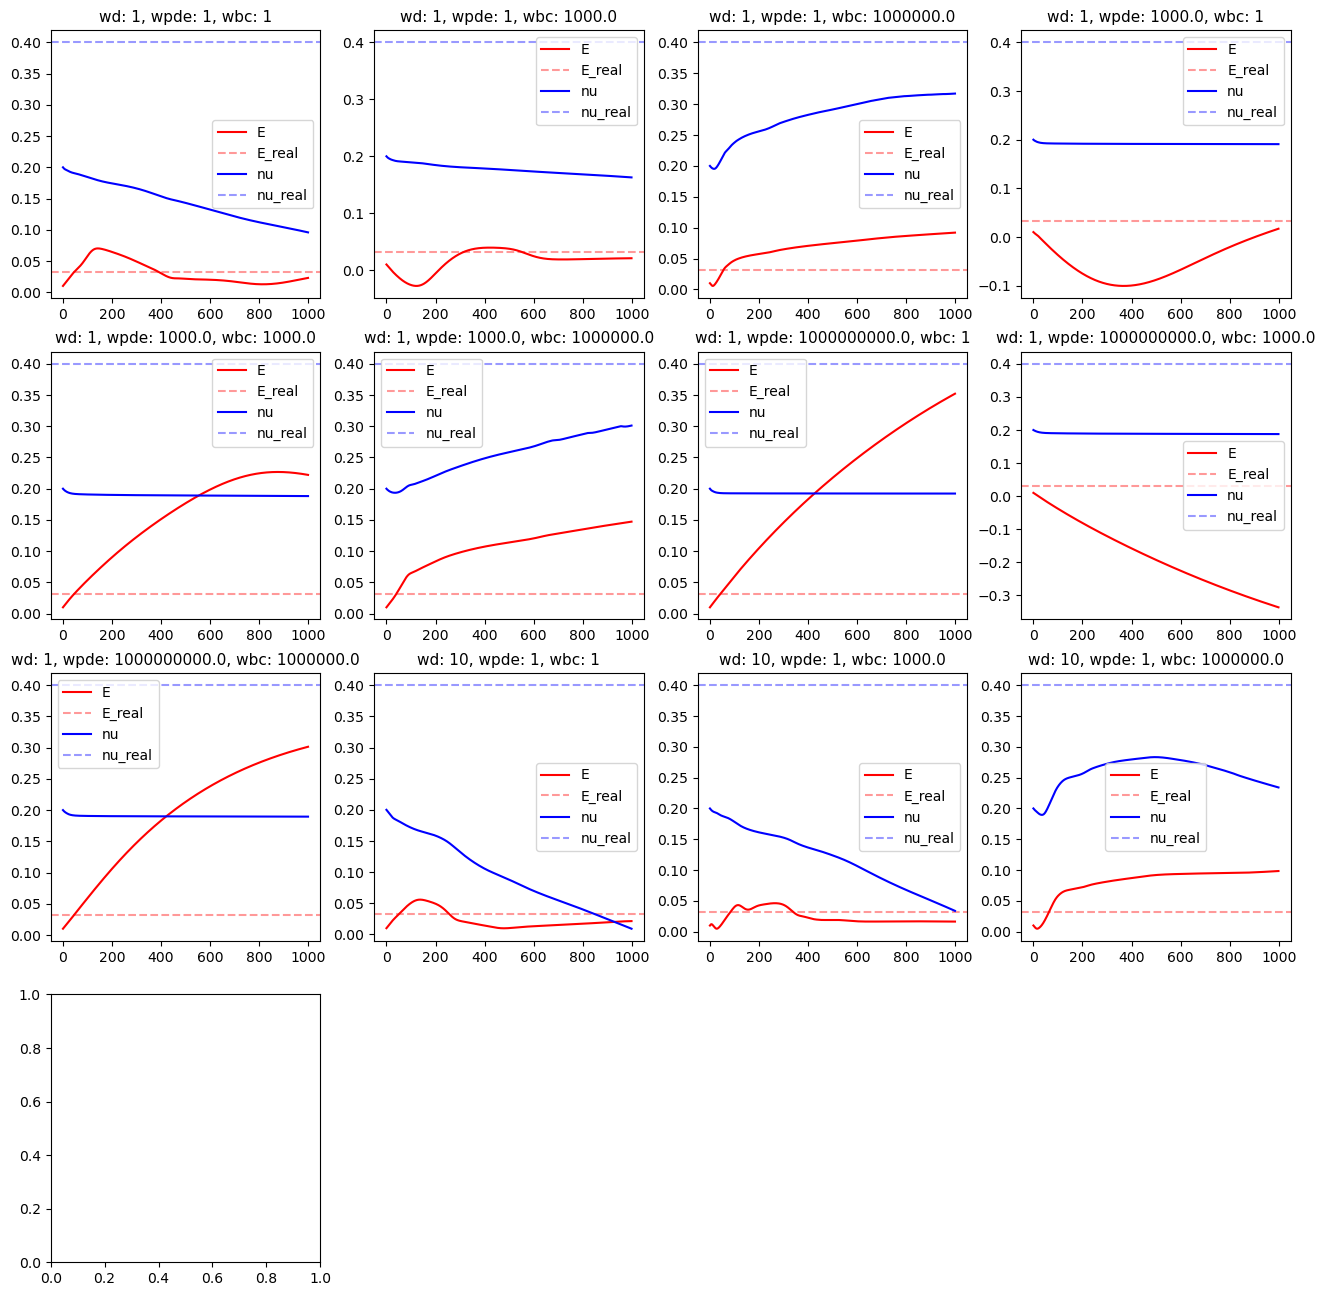

In [34]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(np.arange(epochs),logs_params[i]["E"],color="red",linestyle="-", label='E')
    plt.axhline(E_real,color="red",linestyle="--",label='E_real',alpha=0.4)
    plt.plot(np.arange(epochs),logs_params[i]["nu"],color="blue",linestyle="-", label='nu')
    plt.axhline(nu_real,color="blue",linestyle="--",label='nu_real',alpha=0.4)
    plt.title(f"wd: {logs_params[i]['wd']}, wpde: {logs_params[i]['wpde']}, wbc: {logs_params[i]['wbc']}",fontsize=11)
    plt.legend()

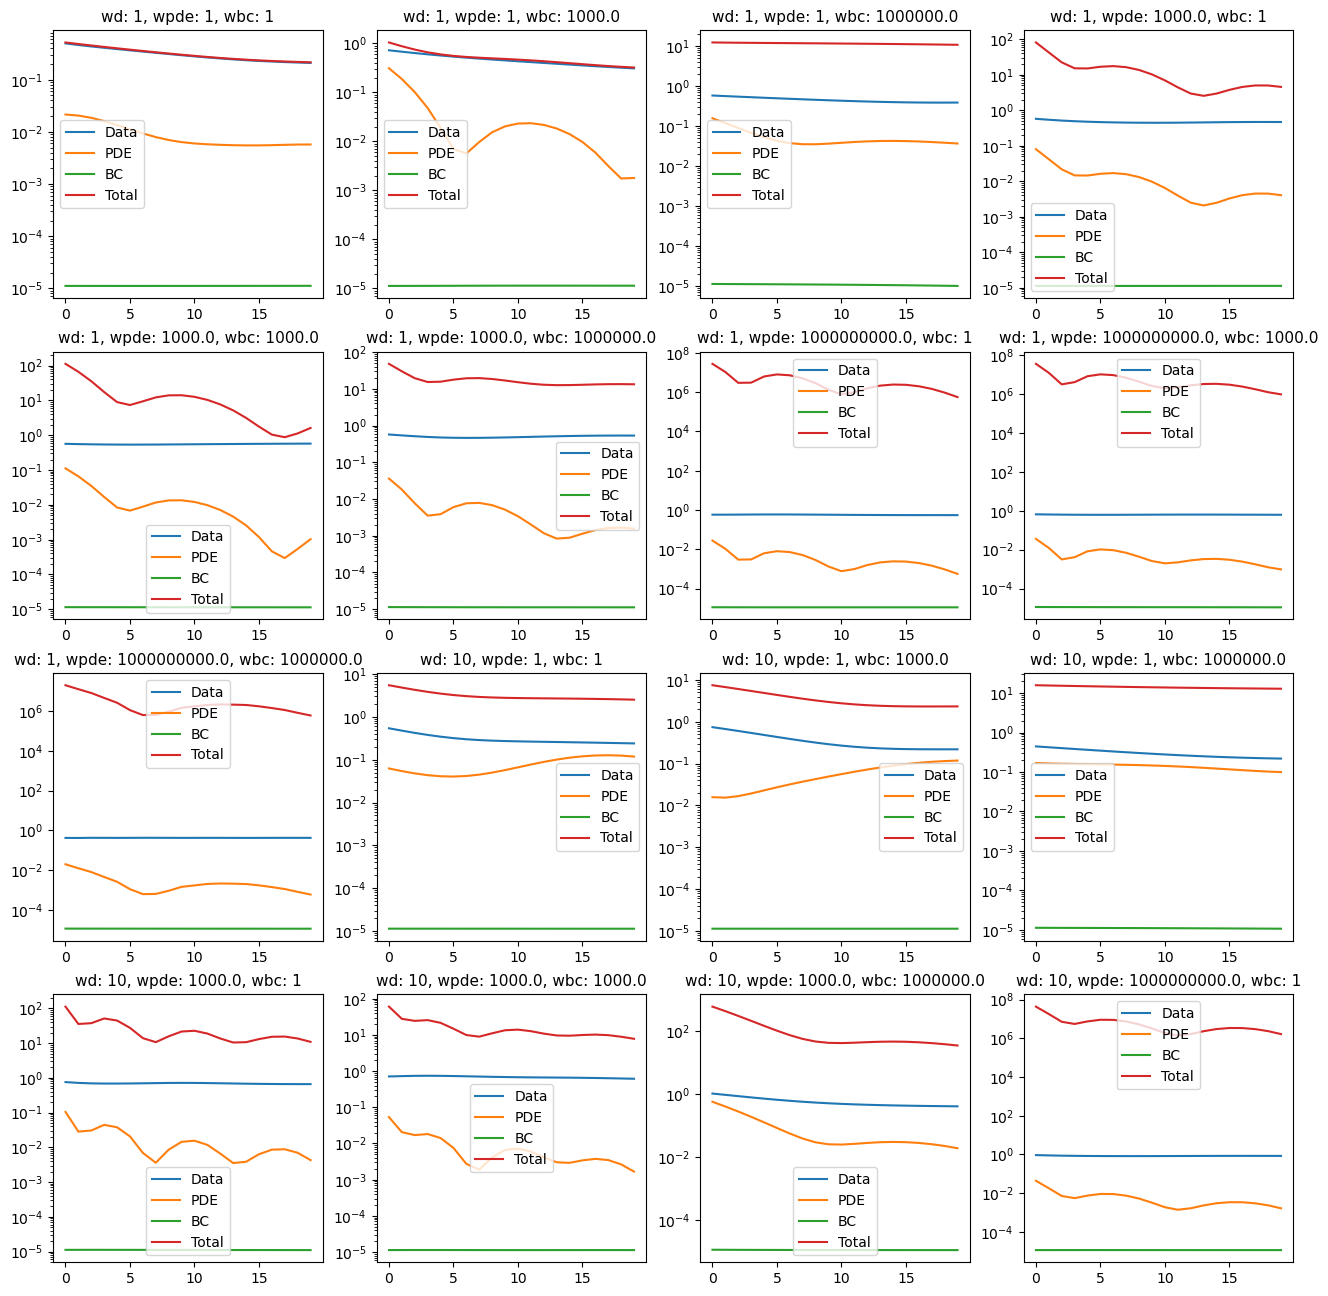

In [29]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(logs_params[i]["loss_history"]["Data"], label='Data')
    plt.plot(logs_params[i]["loss_history"]["PDE"], label='PDE')
    plt.plot(logs_params[i]["loss_history"]["BC"], label='BC')
    plt.plot(logs_params[i]["loss_history"]["Total"], label='Total')
    plt.yscale('log')
    plt.title(f"wd: {logs_params[i]['wd']}, wpde: {logs_params[i]['wpde']}, wbc: {logs_params[i]['wbc']}",fontsize=11)
    plt.legend()